# Método de Metropolis-Hastings

Si bien el **sampleo por rechazo** es una técnica útil, a veces encontrar una buena distribución de propuesta $q(z)$ y una constante $K$ puede ser difícil. En esos casos, el método de **Metropolis-Hastings** es una alternativa efectiva.

Este algoritmo es especialmente útil cuando no podemos directamente muestrear de nuestra distribución objetivo $p(z)$, pero podemos evaluar su densidad.

## Paso a Paso del Método de Metropolis-Hastings:

1. **Elegir una distribución de propuesta $q(z' | z)$**: Esta es una distribución condicional que genera una nueva propuesta $z'$, dada la posición actual $z$. A menudo es simétrica, por ejemplo, una distribución normal centrada en $z$.

2. **Generar una propuesta $z'$**: A partir de $z$, sampleamos un nuevo valor $z'$ de la distribución de propuesta $q(z' | z)$.

3. **Calcular la razón de aceptación $\alpha$**: La razón de aceptación mide qué tan probable es aceptar la nueva propuesta $z'$. Se calcula como:
   
   $\alpha = \frac{p(z') \cdot q(z | z')}{p(z) \cdot q(z' | z)}$
   
   Si la distribución de propuesta es simétrica (por ejemplo, una normal), entonces la razón se simplifica a:
   
   $\alpha = \frac{p(z')}{p(z)}$
   

4. **Generar $u \sim U[0, 1]$**: Realizamos un sampleo de una distribución uniforme.

5. **Aceptar o rechazar la propuesta**:
   - Si $u \leq \alpha$, aceptamos $z'$ como el nuevo valor.
   - Si no, mantenemos el valor actual $z$.

6. **Repetir el proceso**: Esto genera una cadena de Markov que, después de un tiempo, se estabiliza y comienza a producir muestras de la distribución objetivo $p(z)$.

---

Este método es poderoso porque no requiere conocer la normalización exacta de $p(z)$, solo que sea proporcional a la densidad de la distribución objetivo. Además, no siempre es necesario rechazar propuestas tan a menudo como en el sampleo por rechazo, lo que lo hace más eficiente en algunos casos.


# Objetivo


El objetivo va a ser samplear a la distribucion (no normalizada)

$$p(x) = e^{-\frac{x^2}{2}} \left( \sin^2(6+x) + 3 \cdot \cos^2(x) \cdot \sin^2(4x) + 1 \right)
,$$

cuya distribucion acumulada se ve muy muy dificil de encontrar.

# Ejercicio

a) Graficar la función $p(x)$  
b) Implementar el método metrópolis hasting para realizar sampleos de $p$  
c) Graficar el histograma de $p(x)$


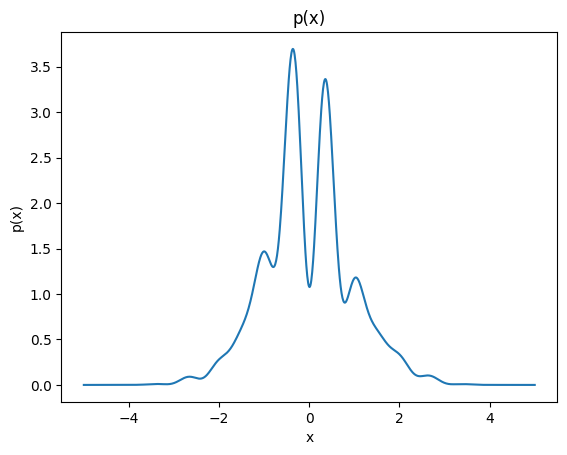

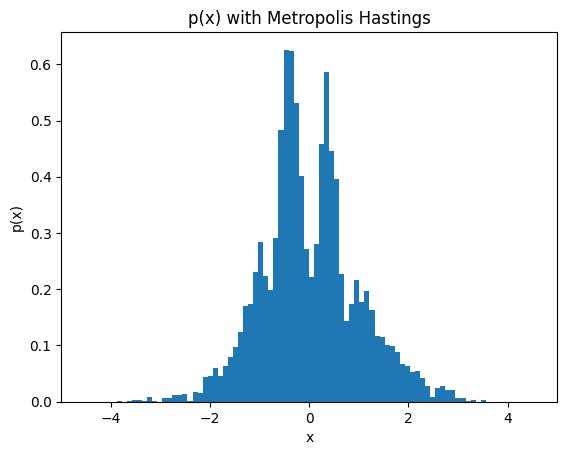

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats


#q(x)
q = stats.norm(loc=0, scale=1)

z=0

# p(x)
def p(x):
    term1 = np.exp(-x**2 / 2)
    term2 = np.sin(6 + x)**2
    term3 = 3 * np.cos(x)**2 * np.sin(4 * x)**2
    return term1 * (term2 + term3 + 1)


plt.plot(np.linspace(-5, 5, 1000), p(np.linspace(-5, 5, 1000)))
plt.xlabel('x')
plt.ylabel('p(x)')
plt.title('p(x)')
plt.show()

list_z = [0]

#Metropolis Hastings
for _ in range (10000):
    z_ = q.rvs()
    alpha = min(1, p(z_) / p(z))
    if alpha == 1: z = z_
    else:
        u = np.random.uniform()
        if u <= alpha: z = z_
    list_z.append(z)
    q = stats.norm(loc=z, scale=1)

plt.hist(list_z, bins='auto', density=True)
plt.xlabel('x')
plt.ylabel('p(x)')
plt.title('p(x) with Metropolis Hastings')
plt.xlim(-5, 5)
plt.show()



# Modelo de Ising

El modelo de Ising es un modelo físico propuesto para estudiar el comportamiento de materiales ferromagnéticos. Se trata de un modelo paradigmático de la Mecánica Estadística. La idea es aproximar los dominios magnéticos (islas con spines agrupados) por un spin promedio. Al formar una red de estos podemos estudiar con el modelo los parámetros termodinamicos (energía interna, magnetización, etc) del sistéma en función de la temperatura.

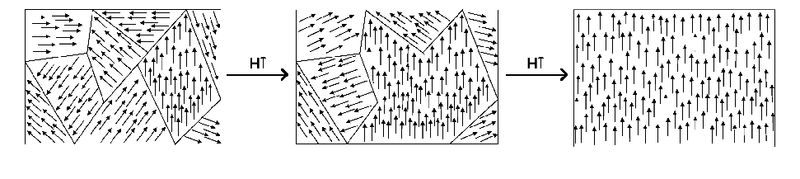


# Metrópolis para Ising 2D.

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

L = 20
S = np.random.choice([-1, 1], size=(L, L))
T = 0.3
beta = 1 / T


In [121]:

from numba import njit

@njit # beta es un dato que nosotros le damos (T).
def energia_total(S): #Calcula la energía por particula de la red en el estado S
  E=0
  L=len(S)
  for i in range(L):
      for j in range(L):
        e=-S[i%L][j%L]*(S[(i-1)%L][j%L]+S[i%L][(j-1)%L]) #H(S)
        E=E+e #e es el incremento de energía que le voy sumando spin a spin con sus vecinos que voy agregando al hamiltoniano con el for para cada i, j
  E=E/(L)**2 #aca divido la energia por L^2 como pide para que sea la energia por particula
  return E

@njit
def energia_local(s, a, b):
    L = len(s)  # Asume que s es cuadrada
    # Calcula la energía del spin en la posición (a, b)
    e = -s[a][b] * (s[(a-1) % L][b] + s[a][(b-1) % L] +
                          s[a][(b+1) % L] + s[(a+1) % L][b])
    return e


# Metropolis_i

Realicen la funcion metropolis_local, la cual debe realizar lo siguiente:


* Obtener una coordenada $(x,y)$ de la matriz $S$
* Calcular la energia local en $(x,y)$
* Cambiar el spin de $(x,y)$ y calcular su nueva energia local
* Calcular el $ΔE$
* Si $ΔE < 0$ le damos vuelta el spin, si $ΔE \geq 0$ lo aceptamos con $p = e^{β ΔE}$



In [107]:
@njit
def metropolis_1_vez(S):
    L = len(S)
    a = np.random.randint(L)
    b = np.random.randint(L)
    e_local = energia_local(S, a, b)
    scopy = S.copy()
    scopy[a][b] *= -1
    e_local_nueva = energia_local(scopy, a, b)
    dE = e_local_nueva - e_local
    if dE < 0: # Acepto el cambio
        S[a][b] *= -1
    elif np.exp(-beta * dE) > np.random.random():
        S[a][b] *= -1
    return S



# Metropolis

Corran metropolis i N veces luego:
* grafiquen S
* Realicen un gráfico de la evolución de la energía.

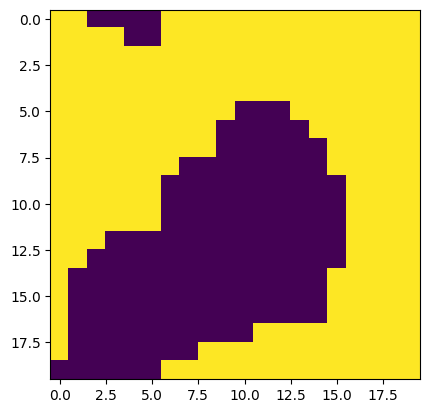

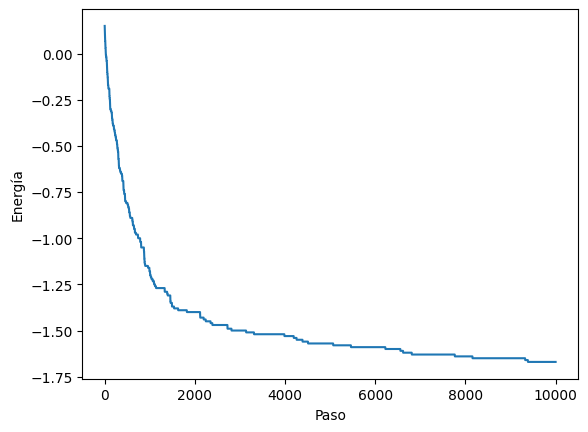

In [108]:
def metropolis(s,N=10):
    energia_tot = []
    for _ in range(N):
        s = metropolis_1_vez(s)
        energia_tot.append(energia_total(s))
    return s, energia_tot

s, energia = metropolis(S, 10000)

plt.imshow(s)
plt.show()
plt.plot(np.arange(10000), energia)
plt.xlabel('Paso')
plt.ylabel('Energía')
plt.show()
